# Preprocessing Setup
Basic steps, because there are domain specific problems to account for later

In [1]:
import pandas as pd
import numpy as np
import re
import spacy
import pkg_resources
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words, wordnet, brown

In [2]:
# !pip install symspellpy

from spacy.cli import download
download('en_core_web_md')
nltk.download('words')
# nltk.download('omw-1.4')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [3]:
# from symspellpy import SymSpell, Verbosity

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
reviews = pd.read_csv("/content/drive/MyDrive/RMP/scraped_comments_with_professor.csv").sample(n=300000, random_state=1)
# reviews[['comment_id', 'firstName', 'lastName', 'prof_class', 'comment', 'clarityRating', 'helpfulRating']].to_csv("/content/drive/MyDrive/RMP/scraped_comments_sample.csv")

In [6]:
reviews.head()

,professor_id,comment_id,firstName,lastName,prof_class,comment,ratingTags,date,attendanceMandatory,grade,clarityRating,difficultyRating,helpfulRating,textbookUse,thumbsDownTotal,thumbsUpTotal,wouldTakeAgain
274508,VGVhY2hlci0xMDY5NDk0,UmF0aW5nLTMwNDk4MTI3,Dianne,Kwasniewski,AH100,I am currently in Ms. Dianne Kwasniewski's AH1...,Respected--Skip class? You won't pass.--Hilarious,2018-09-12 23:18:48 +0000 UTC,NaN,Not sure yet,5,2,5,5.0,0,2,1.0
414595,VGVhY2hlci0xNDMxMzc4,UmF0aW5nLTIyMDk4ODU3,Bruce,Freeman,HUMANRELATIONS,"Pretty easy, all you really need to do is go t...",NaN,2013-09-01 18:04:12 +0000 UTC,Y,A,3,2,4,3.0,0,0,NaN
459567,VGVhY2hlci0xNjA1MDYw,UmF0aW5nLTIzMzk1OTY1,Lorne,Goldstein,CML4111A,"Fantastic class, great guy. Awesome lectures ...",NaN,2014-06-23 19:44:33 +0000 UTC,N,NaN,5,4,4,1.0,0,0,NaN
724268,VGVhY2hlci0xNTQ0NjU3,UmF0aW5nLTE4NzAzODIx,John,Trombley,CHEM1143,He's kinda new to the University. Class is not...,NaN,2011-06-06 15:13:05 +0000 UTC,NaN,NaN,4,3,4,4.0,0,0,NaN
859174,VGVhY2hlci0xMjQ2NTEz,UmF0aW5nLTI3ODQyMDIx,Lawrence,Mc Laughlin,GEOG111,He makes the class easy and the field trips ar...,Respected--Amazing lectures--Caring,2017-02-20 13:14:54 +0000 UTC,mandatory,A,5,2,5,5.0,0,8,1.0


## Duplicates and Nulls

In [7]:
print("Shape before dropping:", reviews.shape)
reviews.drop_duplicates(subset="comment_id", keep="first", inplace=True)

# drop rows containing only "No Comments" (default value assigned by RMP to a review that didn't enter a comment)
reviews = reviews[reviews["comment"] != "No Comments"]

# drop rows containing NaN comment
reviews.dropna(subset=["comment"], inplace=True)

# fill null names with empty string
reviews['firstName'].fillna('', inplace=True)
reviews['lastName'].fillna('', inplace=True)

# Dropping reviews with clarityRating == 3
reviews = reviews[reviews["clarityRating"] != 3]
reviews["sentiment"] = reviews["clarityRating"].apply(lambda x: 1 if x > 2.5 else 0)

print("Shape after dropping:", reviews.shape)
reviews.reset_index(drop=True, inplace=True)

Shape before dropping: (300000, 17)
Shape after dropping: (262645, 18)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


## Removing Urls, Phone Numbers, and Emails

In [8]:
def remove_urls(text):
    return re.sub(r'https?://\S+|www\.\S+', ' ', text)

def remove_phones(text):
    return re.sub(r'\d{3}-\d{3}-\d{4}', ' ', text)

def remove_emails(text):
    return re.sub(r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+', ' ', text)

print(remove_urls('Hey! Check out this link: www.somelink.com'))
print(remove_phones("Hey! Check out this phone number: 742-457-0417"))
print(remove_emails("Hey! Check out this email address: nooneuses@yahoo.com"))

Hey! Check out this link:  
Hey! Check out this phone number:  
Hey! Check out this email address:  


## Html Artifacts

In [9]:
# TODO: Convert html entites of quotes -> "'" to normalize
def remove_html_entities(text):
  text = re.sub('&[0-9a-zA-Z#]+;', ' ', text)
  return re.sub('&#63;?', '', text)

def remove_html_tags(text):
  return re.sub('<.{1,6}?>', ' ', text)

text = "This professor is such an easy &quot;A&quot;, why are y'all struggling &#63;&#63;&#63 </div>"
print(remove_html_entities(text))
print(remove_html_tags(text))

This professor is such an easy  A , why are y'all struggling    </div>
This professor is such an easy &quot;A&quot;, why are y'all struggling &#63;&#63;&#63  


## Emoticon Conversion to Words

In [10]:
#@title Emoticon Mapping
EMOTICONS = {
    u":‑)":"emopos",
    u":-))":"emopos",
    u":-)))":"emopos",
    u":)":"emopos",
    u":))":"emopos",
    u":)))":"emopos",
    u":-]":"emopos",
    u":]":"emopos",
    u":-3":"emopos",
    u":3":"emopos",
    u":->":"emopos",
    u":>":"emopos",
    u"8-)":"emopos",
    u":-}":"emopos",
    u":}":"emopos",
    u":-)":"emopos",
    u":c)":"emopos",
    u":^)":"emopos",
    u"=]":"emopos",
    u"=)":"emopos",
    u":‑D":"emopos",
    u":D":"emopos",
    u"8‑D":"emopos",
    u"8D":"emopos",
    u"X‑D":"emopos",
    u"XD":"emopos",
    u"=D":"emopos",
    u"=3":"emopos",
    u"B^D":"emopos",
    u":-))":"emopos",
    u":-(":"emoneg",
    u":‑(":"emoneg",
    u":(":"emoneg",
    u":‑c":"emoneg",
    u":c":"emoneg",
    u":‑<":"emoneg",
    u":<":"emoneg",
    u":‑[":"emoneg",
    u":[":"emoneg",
    u":-||":"emoneg",
    u">:[":"emoneg",
    u":{":"emoneg",
    u">:(":"emoneg",
    u":'‑(":"emoneg",
    u":'(":"emoneg",
    u":'‑)":"emopos",
    u":')":"emopos",
    u"D‑':":"emoneg",
    u"D:<":"emoneg",
    u"D:":"emoneg",
    u"D8":"emoneg",
    u"D;":"emoneg",
    u"D=":"emoneg",
    u"DX":"emoneg",
    u";‑)":"emopos",
    u";)":"emopos",
    u"*-)":"emopos",
    u"*)":"emopos",
    u";‑]":"emopos",
    u";]":"emopos",
    u";^)":"emopos",
    u":‑,":"emopos",
    u";D":"emopos",
    u":‑P":"emopos",
    u":P":"emopos",
    u"X‑P":"emopos",
    u"XP":"emopos",
    u":‑Þ":"emopos",
    u":Þ":"emopos",
    u"=p":"emopos",
    u":‑/":"emoneg",
    u":/":"emoneg",
    u":-[.]":"emoneg",
    u">:[(\)]":"emoneg",
    u">:/":"emoneg",
    u":[(\)]":"emoneg",
    u"=/":"emoneg",
    u"=[(\)]":"emoneg",
    u":L":"emoneg",
    u"=L":"emoneg",
    u":‑|":"emoneg",
    u":|":"emoneg",
    u"O:‑)":"emopos",
    u"O:)":"emopos",
    u"0:‑3":"emopos",
    u"0:3":"emopos",
    u"0:‑)":"emopos",
    u"0:)":"emopos",
    u":‑b":"emopos",
    u"(>_<)":"emoneg",
    u"(>_<)>":"emoneg",
    u"^_^":"emopos",
    u"(^_^)/":"emopos",
    u"(^O^)／":"emopos",
    u"(^o^)／":"emopos",
    u"('_')":"emoneg",
    u"(/_;)":"emoneg",
    u"(T_T) (;_;)":"emoneg",
    u"(;_;":"emoneg",
    u"(;_:)":"emoneg",
    u"(;O;)":"emoneg",
    u"(:_;)":"emoneg",
    u"(ToT)":"emoneg",
    u";_;":"emoneg",
    u";-;":"emoneg",
    u";n;":"emoneg",
    u"Q.Q":"emoneg",
    u"T.T":"emoneg",
    u"Q_Q":"emoneg",
    u"(-.-)":"emopos",
    u"(-_-)":"emopos",
    u"(；一_一)":"emopos",
    u"(=_=)":"emoneg",
    u"^m^":"emopos",
    u">^_^<":"emopos",
    u"<^!^>":"emopos",
    u"^/^":"emopos",
    u"（*^_^*）" :"emopos",
    u"(^<^) (^.^)":"emopos",
    u"(^^)":"emopos",
    u"(^.^)":"emopos",
    u"(^_^.)":"emopos",
    u"(^_^)":"emopos",
    u"(^^)":"emopos",
    u"(^J^)":"emopos",
    u"(*^.^*)":"emopos",
    u"(^—^）":"emopos",
    u"(#^.^#)":"emopos",
    u"(*^0^*)":"emopos",
    u"(*^^)v":"emopos",
    u"(^_^)v":"emopos",
    u'(-"-)':"emoneg",
    u"(ーー;)":"emoneg",
    u"(＾ｖ＾)":"emopos",
    u"(＾ｕ＾)":"emopos",
    u"(^)o(^)":"emopos",
    u"(^O^)":"emopos",
    u"(^o^)":"emopos",
    u")^o^(":"emopos",
    u":O o_O":"emoneg",
    u"o_0":"emoneg",
    u"o.O":"emoneg",
    u"(o.o)":"emoneg",
    u"(*￣m￣)": "emoneg",
}

for emote, val in EMOTICONS.items():
  EMOTICONS[emote] = val.lower().replace(',', ' ').replace(' ', '_')

In [11]:
def convert_emoticons(text):
  return EMOTICONS.get(text, text)
  
text = "Hello :-) :-)"
text_split = text.split()
for i, txt in enumerate(text_split):
  text_split[i] = convert_emoticons(txt)
print(' '.join(text_split))

Hello emopos emopos


## Contractions

In [12]:
#@title Contraction Mapping
contraction_mapping = {
    "ain't": "is not", 
    "aren't": "are not",
    "can't": "cannot",
    "'cause": "because", 
    "could've": "could have", 
    "couldn't": "could not", 
    "didn't": "did not",  
    "doesn't": "does not", 
    "don't": "do not", 
    "hadn't": "had not", 
    "hasn't": "has not", 
    "haven't": "have not", 
    "he'd": "he would",
    "he'll": "he will", 
    "he's": "he is", 
    "how'd": "how did", 
    "how'd'y": "how do you", 
    "how'll": "how will", 
    "how's": "how is",  
    "I'd": "I would", 
    "I'd've": "I would have", 
    "I'll": "I will", 
    "I'll've": "I will have",
    "I'm": "I am", 
    "I've": "I have", 
    "i'd": "i would", 
    "i'd've": "i would have", 
    "i'll": "i will",  
    "i'll've": "i will have",
    "i'm": "i am", 
    "i've": "i have", 
    "isn't": "is not", 
    "it'd": "it would", 
    "it'd've": "it would have", 
    "it'll": "it will", 
    "it'll've": "it will have",
    "it's": "it is", 
    "let's": "let us", 
    "ma'am": "madam", 
    "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [13]:
def expand_contraction(text): # Before expanding contraction, might want to clean of symbols that are not '
  return contraction_mapping.get(text, text)

text = "You're a pig and I should've slayed you, grrr"
text_split = text.split()
for i, txt in enumerate(text_split):
  text_split[i] = expand_contraction(txt.lower())
print(' '.join(text_split))

you are a pig and i should have slayed you, grrr


## Spellchecker

In [14]:
# sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
# dictionary_path = pkg_resources.resource_filename(
#     "symspellpy", "frequency_dictionary_en_82_765.txt"
# )
# # term_index is the column of the term and count_index is the
# # column of the term frequency
# sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# # lookup suggestions for single-word input strings
# input_term = "memebers"  # misspelling of "members"

# # Verbosity.TOP gets the best suggestion
# suggestion = sym_spell.lookup(input_term, Verbosity.TOP, max_edit_distance=2)
# print(suggestion[0], len(suggestion))

## Stopwords

In [247]:
# amend list of stop words to keep whatever it is we want by removing words from list that we want to keep

# TODO: is the list of stopwords on git complete and accurate or does someone want to read through all 325 stopwords spacy gives and determine which ones to keep?
# stopwords = STOP_WORDS
# stopwords.remove("but")
# stopwords.remove("not")
# stopwords.remove("nor")
# stopwords.remove("never")
stopwords = set(["mr", "ms", "dr"])

## Spacy Setup

In [248]:
nlp = spacy.load('en_core_web_sm', exclude=['lemmatizer', 'parser', 'textcat', 'custom'])

# Preprocessing Pipeline

In [321]:
comments_proper = []
spellchecked_comments = []
cnt = 0 # to keep track of progress
lemm = WordNetLemmatizer()
grades = set(['a', 'b', 'c', 'd', 'e', 'f'])
unseen = Counter()

for index, review in reviews.iterrows():
  comment = review['comment']
  fname = review['firstName'].lower().split(' ')
  lname = review['lastName'].lower().split(' ')
  names = set(fname + lname)

  cnt += 1
  if cnt % 25000 == 0:
    print(cnt)

  comment = remove_urls(comment)
  comment = remove_phones(comment)
  comment = remove_emails(comment)
  comment = remove_html_entities(comment)
  comment = remove_html_tags(comment)

  comment_split = comment.split(' ')
  new_comment_split = []
  for i, word in enumerate(comment_split):
    word = convert_emoticons(word)
    word = word.lower()
    # word = expand_contraction(word)
    word = re.sub("[^a-zA-Z\s]+", ' ', word)   # replace characters that are not alphabetic, space, or underscore
    # word = word.replace("'", ' ') # replace apostrophe with space
    word = re.sub(r'(.)\1\1+', '\g<1>', word)  # replace any three character+ sequence with one
    word = re.sub('\s+', ' ', word)
    word = word.strip() # trailing whitespace because punctuation replaced by space
    # if word not in names:
    new_comment_split.extend(word.split(' '))

  # comment = comment.lower()
  # comment = re.sub("[^a-zA-Z\s]+", ' ', comment)   # replace characters that are not alphabetic, space, or underscore
  # comment = comment.replace("'", '') # remove apostrophes
  # comment = re.sub(r'(.)\1\1+', '\g<1>', comment)  # replace any three characters sequence with one
  # comment = re.sub('\s+', ' ', comment)
  # comment = comment.strip() # trailing whitespace because punctuation replaced by space

  
  # comment_split = comment.split(' ')
  # new_comment_split = []
  # for i, word in enumerate(comment_split):
  #   if word not in names:
  #     new_comment_split.append(word)

  # Remove names from the comment
  for i, word in enumerate(new_comment_split):
    if word in names:
      new_comment_split[i] = ''

  comment = ' '.join(new_comment_split)
  comment = re.sub('\s+', ' ', comment)
  comment = comment.strip()

  # comment = [lemm.lemmatize(word) for word in comment.split()] # Lemmatize and remove stopwords
  # comment = [word for word in comment.split() if word not in stopwords] # remove stopwords
  # comment = " ".join(comment)

  comment = ' '.join(word for word in comment.split() if len(word) > 1)

  comments_proper.append(comment)
  # spellchecked_comments.append(' '.join(sym_spell.lookup(word, Verbosity.TOP, max_edit_distance=2, include_unknown=True)[0].term for word in comment.split()))

25000
50000
75000
100000
125000
150000
175000
200000
225000
250000


In [322]:
unseen_words = Counter()
people = Counter()
def preprocess_pipe(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=200):
      # for word in doc:
      #   if word.pos_ == 'PROPN':
      #     unseen_words[word.text] += 1
      #     print(word.text, word.pos_)
      # print(doc.ents)
      for word in doc.ents:
        if word.label_ == 'PERSON':
          people[word.text] += 1
          # print(word.text,word.label_)

# preprocess_pipe(comments_proper)
# print(unseen_words, len(unseen_words))
# print(people, len(people))

In [323]:
print(people)

Counter()


In [324]:
# i = 0
# for comment, spellcheck_comment in zip(comments_proper, spellchecked_comments):
#   print(comment)
#   print(spellcheck_comment)
#   print('\n')
#   i += 1
#   if i == 10:
#     break

In [325]:
reviews["cleanedComment"] = pd.Series(comments_proper)
# reviews["cleanedCommentChecked"] = pd.Series(spellchecked_comments)
reviews['cleanedComment'].head(25)

0     am currently in ms ah course and couldn help b...
1     fantastic class great guy awesome lectures go ...
2     he kinda new to the university class is not th...
3     he makes the class easy and the field trips ar...
4     she awesome very helpful and fun cuts you alot...
5     mr was great very helpful and so caring really...
6     the entry before mine makes me believe the dud...
7     hi is the best teacher like his class because ...
8     loved this class super easy to follow along no...
9     this professor was getting treatment for cance...
10    great professor she explains material very wel...
11    worst teacher in msu and probably the history ...
12    took prof for last semester loved her but this...
13    take her for winter for winter class it was ea...
14                                 take another teacher
15    she is obviously web designer and seems to kno...
16    while loved the class and learned lot about my...
17    most confusing instructions and direction 

In [326]:
reviews['sentiment'].value_counts()

1    195995
0     66650
Name: sentiment, dtype: int64

In [327]:
for index, row in reviews.head(50).iterrows():
    print(row['comment'])
    print(row['cleanedComment'])
    print('\n')

I am currently in Ms. Dianne Kwasniewski's AH100 course and I couldn't help but get on here and give her a review. Truly one of the best professors (if not the best) I have had while attending HFC. 10/10 would recommend her to anyone for AH100. She's very educated in her field and will make it very easy to pass as long as you study and do your work
am currently in ms ah course and couldn help but get on here and give her review truly one of the best professors if not the best have had while attending hfc would recommend her to anyone for ah she very educated in her field and will make it very easy to pass as long as you study and do your work


Fantastic class, great guy.  Awesome lectures - go to them, even though you don't have to.  But don't expect to be spoonfed the course material.  You have to figure it out for yourself and engage with it.  (Psst - that's a good thing.)
fantastic class great guy awesome lectures go to them even though you don have to but don expect to be spoonfed

In [328]:
# dropping rows <= 5
# reviews['wordCount'] = reviews["cleanedComment"].str.split().str.len()
# reviews[['wordCount', 'cleanedComment']].head(5)

# reviews = reviews[reviews['wordCount'] > 5]
# reviews.shape
reviews = reviews.loc[:, ["firstName", "lastName", "comment", "cleanedComment", "clarityRating", "sentiment", "professor_id"]]

# Document Sentiment Pipeline

In [329]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score

from sklearn.feature_selection import chi2, SelectPercentile
from sklearn.pipeline import Pipeline

In [330]:
def evalPerformance(y_pred, y_test, mode="weighted"):
    acc_score = accuracy_score(y_test, y_pred)
    print("Accuracy Score: " + str(acc_score * 100))
    
    f1 = f1_score(y_test, y_pred, average=mode)
    print("F1 Score: {0}".format(f1 * 100))

In [331]:
prof_counts = reviews["professor_id"].value_counts()
prof_train, prof_test, cnt_train, cnt_test = train_test_split(prof_counts.index, prof_counts.values, test_size=0.2, random_state=1)
del cnt_train, cnt_test

In [332]:
comm_train = reviews[reviews["professor_id"].isin(prof_train)]["cleanedComment"]
comm_test = reviews[reviews["professor_id"].isin(prof_test)]["cleanedComment"]

sent_train = reviews[reviews["professor_id"].isin(prof_train)]["sentiment"]
sent_test = reviews[reviews["professor_id"].isin(prof_test)]["sentiment"]

In [333]:
sent_pipeline = Pipeline([
    ("vectorizer", CountVectorizer(ngram_range=(1,2), max_df=0.5)), 
    ("selector"  , SelectPercentile(score_func=chi2, percentile=50)),
    ("classifer" , MultinomialNB())
])

In [334]:
sentiment_fit = sent_pipeline.fit(comm_train, sent_train)

In [335]:
sent_pred = sent_pipeline.predict(comm_test)

In [336]:
evalPerformance(sent_pred, sent_test)

Accuracy Score: 93.22982075579404
F1 Score: 93.19393620187566


## Accuracy

In [337]:
# Test accuracy of model
from sklearn.metrics import confusion_matrix, accuracy_score

conf_m = confusion_matrix(sent_test, sent_pred)

acc_score = accuracy_score(sent_test, sent_pred)

print("Accuracy Score: " + str(acc_score * 100))
print(conf_m)

# Baseline 300k, basic preprocess: 93.21459%
# 300k, preprocess + name removal: 93.2165%
# 300k, preprocess + name removal + emoticons: 93.2279%
# 300k, preprocess + true name removal + emoticons: 93.2298%  ** True removal because it is more in depth remove
# 300k, preprocess + name removal + emoticons + contraction expansion

Accuracy Score: 93.22982075579404
[[11475  1991]
 [ 1567 37521]]


In [338]:
# del X, y, X_train, X_test, y_train, y_test, model, y_pred

# EDA

In [339]:
import matplotlib.pyplot as plt
import seaborn as sns

In [340]:
positive_reviews = reviews[reviews.sentiment == 1]
negative_reviews = reviews[reviews.sentiment == 0]

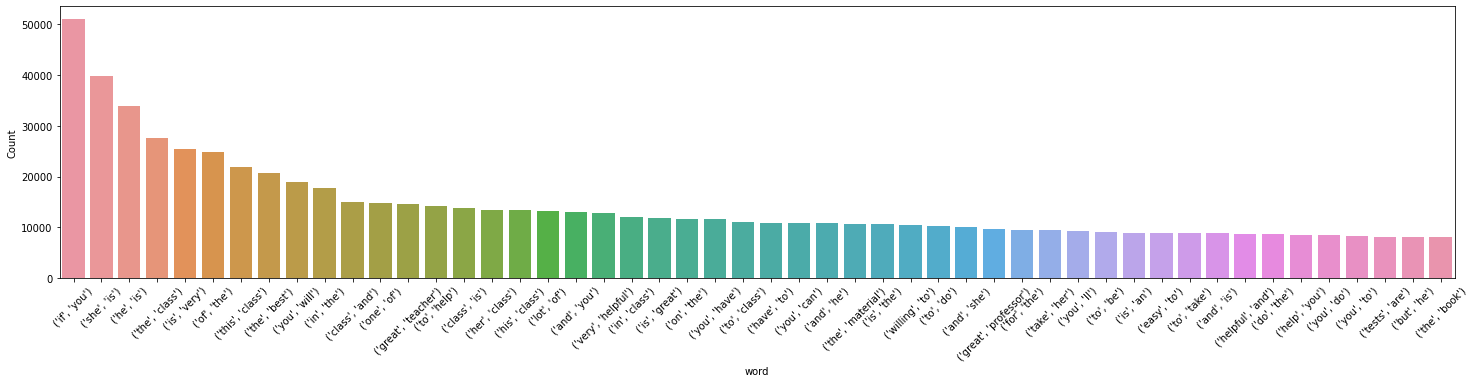

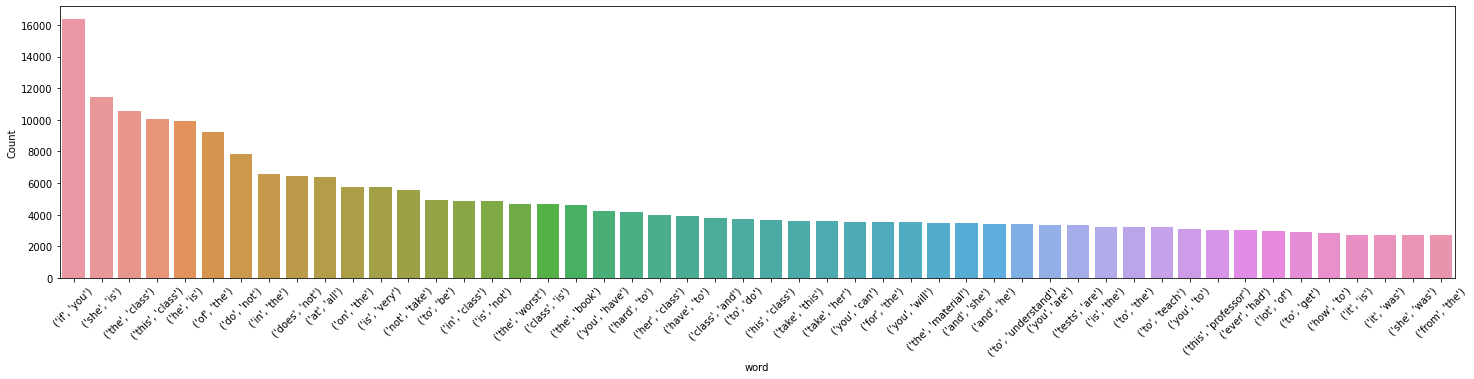

In [341]:
from nltk import FreqDist

%matplotlib inline
def freq_ngrams(x, terms=40, n=1):        # function to plot most frequent n-grams
    all_words = " ".join([text for text in x])
    all_words = all_words.split()

    ngs = nltk.ngrams(all_words, n)
    fdist = FreqDist(ngs)
    words_df = pd.DataFrame({"word":list(fdist.keys()), "count":list(fdist.values())})

    d = words_df.nlargest(columns="count", n=terms)
    plt.figure(figsize=(25,5))
    plt.xticks(rotation=45)
    ax = sns.barplot(data=d, x="word", y="count")
    ax.set(ylabel="Count")
    plt.show()

freq_ngrams(positive_reviews['cleanedComment'], terms=50, n=2)
freq_ngrams(negative_reviews['cleanedComment'], terms=50, n=2)

In [342]:
# print(cv.stop_words_)
# print(len(cv.stop_words_))

In [343]:
all_words = set()
for comment in reviews['cleanedComment']:
  unique_words_comment = set(comment.split(' '))
  all_words.update(unique_words_comment)


In [344]:
len(all_words) # 52002

52004

# Possible Improvements
* Could engineer new features using words that are capitalized in the review
* Remove reviews that're not english